In [ ]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 13.3 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 
     |████████████████████████████████| 77 kB 4.7 MB/s 
     |████████████████████████████████| 6.5 MB 64.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [ ]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [ ]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      left = citation_contexts[j]['left_ctx']
      left_tokens=[]
      for l in range(len(left)):
        left_tokens.append(left[l]['tokens_pp'])
      right = citation_contexts[j]['right_ctx']
      right_tokens=[]
      for r in range(len(right)):
        right_tokens.append(right[r]['tokens_pp'])
      
      left_tokens=[item for tokens in left_tokens for item in tokens]
      right_tokens=[item for tokens in right_tokens for item in tokens]
      l=len(left_tokens)
      tokens = left_tokens + tokens + right_tokens
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            c = c + l
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [ ]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[Despite, their, large, length, difference, ,, the, two, 0002, sentences, are, still, aligned, as, a, 1, -, 1, pair, ,, because, the, sentences, in, the, following, 4, alignments, (, 0003, -, 0003, ;, 0004, -, 0004, ,, 0005, ;, 0005, -, 0006, ;, 0006, -, 0007, ), have, rather, similar, HTML, markups, and, are, taken, by, the, program, to, be, the, most, likely, alignments, ., Beside, HTML, mar...",Future,97,"Despite their large length difference , the two 0002 sentences are still aligned as a 1 - 1 pair , because the sentences in the following 4 alignments ( 0003 - 0003 ; 0004 - 0004 , 0005 ; 0005 - 0006 ; 0006 - 0007 ) have rather similar HTML markups and are taken by the program to be the most likely alignments . Beside HTML markups , other criteria may also be incorporated . For example , it wo..."
1,"[Previous, work, has, argued, that, initiative, affects, the, degree, of, control, an, agent, has, in, the, dialogue, interaction, (, CITSEG, ), ., Thus, ,, a, cooperative, system, may, adopt, different, strategies, to, achieve, the, same, goal, depending, on, the, initiative, distribution, ., Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialog...",Future,84,"Previous work has argued that initiative affects the degree of control an agent has in the dialogue interaction ( CITSEG ) . Thus , a cooperative system may adopt different strategies to achieve the same goal depending on the initiative distribution . Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strateg..."
2,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,82,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
3,"[In, this, paper, we, have, provided, an, original, mathematical, argument, in, favour, of, this, thesis, ., Our, results, hold, for, bilexical, context, -, free, grammars, and, directly, transfer, to, several, language, models, that, can, be, seen, as, stochastic, versions, of, this, formalism, (, see, Section, 1, ), ., We, perceive, that, these, results, can, be, extended, to, other, languag...",Future,86,In this paper we have provided an original mathematical argument in favour of this thesis . Our results hold for bilexical context - free grammars and directly transfer to several language models that can be seen as stochastic versions of this formalism ( see Section 1 ) . We perceive that these results can be extended to other language models that properly embed bilexical context - free gramm...
4,"[Future, work, will, involve, testing, our, approach, with, higher, -, discrimination, datasets, ,, developing, methods, to, pre-process, review, texts, (, e.g., ,, improved, negation, tagging, ,, and, incorporating, partof, -, speech, tagging, ), ,, and, further, addressing, the, problem, of, overfitting, ., To, this, effect, we, will, investigate, different, feature, selection, algorithms, ,...",Future,76,"Future work will involve testing our approach with higher - discrimination datasets , developing methods to pre-process review texts ( e.g. , improved negation tagging , and incorporating partof - speech tagging ) , and further addressing the problem of overfitting . To this effect we wi

**Visualising Citation Function Present**

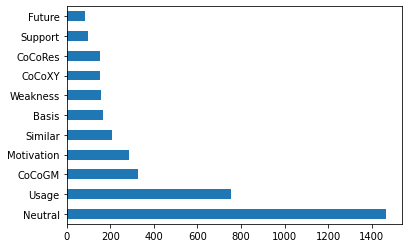

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

In [ ]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [ ]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

**Converting 11 labels to 6 labels**

In [ ]:
citation['Cit_func'].replace({'Support':'Comparison or Contrast','Neutral':'Background','CoCoXY':'Background','Weakness':'Comparison or Contrast',
                                    'CoCoGM':'Comparison or Contrast','Usage':'Uses','Basis':'Extends','CoCoRes':'Comparison or Contrast',
                                    'Similar':'Comparison or Contrast'}, inplace=True)

In [ ]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Comparison or Contrast', 'Extends', 'Background',
       'Motivation', 'Uses'], dtype=object)

**One- hot encoding for labels**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [ ]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [ ]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[Starting, with, (, CITSEG, ), ,, testsuites, have, been, drawn, up, from, a, linguistic, viewpoint, ,, "", in, -, ], ormed, by, [, the, ], study, of, linguistics, and, [, reflecting, ], the, grammatical, issues, that, linguists, have, concerned, themselves, with, "", (, CITSEG, ,, ,, p.4, ), ., Although, the, question, is, not, explicitly, addressed, in, (, CITSEG, ), ,, all, the, testsuites, r...",Background,85,"Starting with ( CITSEG ) , testsuites have been drawn up from a linguistic viewpoint , "" in - ] ormed by [ the ] study of linguistics and [ reflecting ] the grammatical issues that linguists have concerned themselves with "" ( CITSEG , , p.4 ) . Although the question is not explicitly addressed in ( CITSEG ) , all the testsuites reviewed there also seem to follow the same methodology . The TSNL...",0,train
1,"[The, use, of, terms, and, indices, has, parallels, to, proposals, due, to, Kehler, and, Kamp, (, CITSEG, ), ., Kehler, adopts, an, analysis, where, (, referential, ), arguments, to, verbs, are, represented, as, related, to, a, Davidsonian, event, via, thematic, role, functions, ,, e.g., agent, (, e, ), --, john, ), ., Pronouns, typically, refer, to, these, functions, ,, e.g., he-agent, (, e, ...",Background,16,"The use of terms and indices has parallels to proposals due to Kehler and Kamp ( CITSEG ) . Kehler adopts an analysis where ( referential ) arguments to verbs are represented as related to a Davidsonian event via thematic role functions , e.g. agent ( e ) -- john ) . Pronouns typically refer to these functions , e.g. he-agent ( e ) . In VP ellipsis , strict identity corresponds to copying the ...",0,train
2,"[Habert, and, colleagues, (, CITSEG, ), have, been, developing, a, workstation, for, specifying, subcorpora, according, to, text, type, ,, using, Biber, -, style, analyses, ,, among, others, ., In, CITSEG, we, present, a, first, pass, at, quantifying, similarity, between, corpora, ,, and, CITSEG, continues, this, line, of, work, ., As, mentioned, above, ,, CITSEG, directly, address, the, relat...",Background,53,"Habert and colleagues ( CITSEG ) have been developing a workstation for specifying subcorpora according to text type , using Biber - style analyses , among others . In CITSEG we present a first pass at quantifying similarity between corpora , and CITSEG continues this line of work . As mentioned above , CITSEG directly address the relation between NLP systems and text type ; one further such i...",0,train
3,"[However, ,, there, are, at, least, three, arguments, against, iterating, PT, ., First, of, all, ,, iteration, would, increase, the, complexity, of, building, a, model, of, a, paragraph, ;, infinite, iteration, would, almost, certainly, make, impossible, such, a, construction, in, real, time, ., Secondly, ,, the, cooperative, principle, of, CITSEG, ,, under, the, assumption, that, referential,...",Background,49,"However , there are at least three arguments against iterating PT . First of all , iteration would increase the complexity of building a model of a paragraph ; infinite iteration would almost certainly make impossible such a construction in real time . Secondly , the cooperative principle of CITSEG , under the assumption that referential levels of a writer and a reader are quite similar , impl...",0,train
4,"[(, k, ), odall, 's, aeco, ,, mt, does, not, deal, with, examples, such, as, (, 171, ), ), ,, which, he, argues, to, I, ), e, examples, of, 'a, different, phenomcaon, ,, llowew, ;r, flmse, can, be, incorporated, into, a, ad, ), aeco, ,, nt, (, e.g., Moltmamh, 1992, ), ., There, are, various, technical, difliculties, with, Geedali, 's, account, (, see, e.g., CITSEG, ), ., There, is, also, a, f'...",Background,102,"( k ) odall 's aeco , mt does not deal with examples such as ( 171 ) ) , which he argues to I ) e examples of 'a different phenomcaon , llowew ;r flmse can be incorporated into a ad ) aeco , nt ( e.g. Moltmamh 1992 

**Some visualizations after splitting the Dataset**

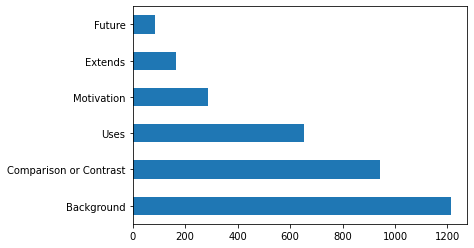

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

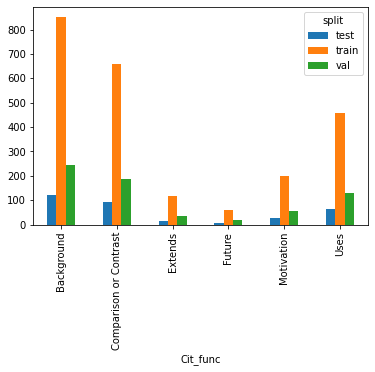

In [ ]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
citation.groupby(['Cit_func','split']).size()

Cit_func                split
Background              test     121
                        train    850
                        val      243
Comparison or Contrast  test      94
                        train    660
                        val      188
Extends                 test      16
                        train    116
                        val       33
Future                  test       8
                        train     59
                        val       17
Motivation              test      28
                        train    201
                        val       57
Uses                    test      65
                        train    458
                        val      131
dtype: int64

**Tokenizer**

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [ ]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2344, 6)
(669, 6)
(332, 6)


**Shuffling the data splits**

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [ ]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 500)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 500)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 500)

In [ ]:
input_ids_train.shape

(2344, 500)

**Calculating position of Citseg in tokenised text**

In [ ]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [ ]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [ ]:
len(id_train)

2344

**Adding Citseg position to Dataframes**

In [ ]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [ ]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[What, we, have, called, a, context, -, free, λ-, term, grammar, is, nothing, but, an, alternative, notation, for, an, abstract, categorial, grammar, (, de, Groote, ,, 2001, ), whose, abstract, vocabulary, is, second, -, order, ,, with, the, restriction, to, linear, λ-terms, removed, ., In, the, linear, case, ,, CITSEG, has, shown, the, recognition, /, parsing, complexity, to, be, PTIME, ,, an...",Comparison or Contrast,104,"What we have called a context - free λ- term grammar is nothing but an alternative notation for an abstract categorial grammar ( de Groote , 2001 ) whose abstract vocabulary is second - order , with the restriction to linear λ-terms removed . In the linear case , CITSEG has shown the recognition / parsing complexity to be PTIME , and exhibited an algorithm similar to Earley parsing for TAGs . ...",1,train,118
1,"[The, high, and, consistent, levels, of, agreement, for, our, task, suggest, that, we, have, found, a, useful, experimental, formulation, of, the, task, of, discourse, segmentation, ., Furthermore, ,, our, percent, agreement, figures, are, comparable, with, the, results, of, other, segmentation, studies, discussed, above, ., While, studies, of, other, tasks, have, achieved, stronger, results, ...",Comparison or Contrast,66,"The high and consistent levels of agreement for our task suggest that we have found a useful experimental formulation of the task of discourse segmentation . Furthermore , our percent agreement figures are comparable with the results of other segmentation studies discussed above . While studies of other tasks have achieved stronger results ( e.g. , 96.8 % in a word - sense disambiguation study...",1,train,73
2,"[Our, method, differs, from, theirs, in, that, we, enrich, the, coverage, of, WordNet, using, two, methods, of, automatic, thesatmm, construction, ,, and, we, weight, the, expausion, term, appropriately, so, that, it, can, accommodate, the, polysemous, word, problem, ., Although, Stairmand, (, CITSEG, ), and, Richardson, (, CITSEG, ), have, proposed, the, use, of, WordNet, in, information, ret...",Extends,85,"Our method differs from theirs in that we enrich the coverage of WordNet using two methods of automatic thesatmm construction , and we weight the expausion term appropriately so that it can accommodate the polysemous word problem . Although Stairmand ( CITSEG ) and Richardson ( CITSEG ) have proposed the use of WordNet in information retrieval , they did not used WordNet in the query expansion...",2,train,102
3,"[c, −, =, arg, max, c, ∈, C, ;, c, =y, +, s, θ, (, x, ), c, ., For, tasks, where, the, number, of, classes, is, large, ,, we, can, fix, a, number, of, negative, classes, to, be, considered, at, each, example, and, select, the, one, with, the, largest, score, to, perform, a, gradient, step, ., This, approach, is, similar, to, the, one, used, by, CITSEG, to, select, negative, examples, ., We, us...",Comparison or Contrast,66,"c − = arg max c ∈ C ; c =y + s θ ( x ) c . For tasks where the number of classes is large , we can fix a number of negative classes to be considered at each example and select the one with the largest score to perform a gradient step . This approach is similar to the one used by CITSEG to select negative examples . We use the backpropagation algorithm to compute gradients of the network . In o...",1,train,68
4,"[We, used, two, datasets, ,, customer, reviews, (, CITSEG, ), and, movie, reviews, (, CITSEG, ), to, evaluate, sentiment, classification, of, sentences, ., Both, of, these, two, datasets, are, often, used, for, evaluation, in, sentiment, analysis, researches, ., The, number, of, examples, and, other, statistics, of, the, datasets, are, shown, in, Table, 1, ., Our, method, cannot, be, applied, ...",Uses,8,"We used two datasets , customer reviews ( CITSEG ) and movie reviews ( CITSEG ) to evaluate sentiment classification of sentences . Both of these two datasets are of

In [ ]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[A, recent, trend, in, natural, language, processing, has, been, toward, a, greater, emphasis, on, statistical, approaches, ,, beginning, with, the, success, of, statistical, part-of, -, speech, tagging, programs, (, CITSEG, ), ,, and, continuing, with, other, work, using, statistical, part-of, -, speech, tagging, programs, ,, such, as, BBN, PLUM, (, CITSEG, ), and, NYU, Proteus, (, CITSEG, ),...",Background,72,"A recent trend in natural language processing has been toward a greater emphasis on statistical approaches , beginning with the success of statistical part-of - speech tagging programs ( CITSEG ) , and continuing with other work using statistical part-of - speech tagging programs , such as BBN PLUM ( CITSEG ) and NYU Proteus ( CITSEG ) . More recently , statistical methods have been applied to...",0,val,82
1,"[For, this, system, ,, the, main, goals, are, that, an, executable, plan, which, meets, the, user, 's, goals, is, constructed, and, agreed, upon, by, both, the, system, and, the, user, and, then, that, the, plan, is, executed, ., The, dialogue, manager, must, keep, track, of, the, current, state, of, the, dialogue, ,, determine, the, effects, of, observed, conversation, acts, ,, generate, utte...",Uses,90,"For this system , the main goals are that an executable plan which meets the user 's goals is constructed and agreed upon by both the system and the user and then that the plan is executed . The dialogue manager must keep track of the current state of the dialogue , determine the effects of observed conversation acts , generate utterances back , and send commands to the domain plan reasoner an...",5,val,95
2,"[CITSEG, have, noted, the, importance, of, a, cooperative, system, providing, support, for, its, responses, ., They, identified, strategies, that, a, system, can, adopt, in, justifying, its, beliefs, ;, however, ,, they, did, not, specify, the, criteria, under, which, each, of, these, strategies, should, be, selected, ., CITSEG, described, a, method, of, determining, when, to, include, optiona...",Comparison or Contrast,46,"CITSEG have noted the importance of a cooperative system providing support for its responses . They identified strategies that a system can adopt in justifying its beliefs ; however , they did not specify the criteria under which each of these strategies should be selected . CITSEG described a method of determining when to include optional warrants to justify a claim based on factors such as c...",1,val,48
3,"[There, are, several, stategies, that, might, be, pursued, ., One, is, to, adopt, Pinkal, 's, "", radical, underspecification, "", approach, (, CITSEG, ), and, use, underspecified, representations, for, all, types, of, ambiguity, ,, even, syntactic, ambiguity, ., The, more, conservative, approach, is, to, try, to, integrate, existing, statistical, disambiguation, schemes, for, QLFs, ,, either, i...",Future,63,"There are several stategies that might be pursued . One is to adopt Pinkal 's "" radical underspecification "" approach ( CITSEG ) and use underspecified representations for all types of ambiguity , even syntactic ambiguity . The more conservative approach is to try to integrate existing statistical disambiguation schemes for QLFs , either individually or in a "" packed "" structure ( CITSEG ) , w...",3,val,74
4,"[To, rescore, the, N, -, best, lists, ,, we, use, the, method, of, ., But, the, results, shown, here, are, different, from, that, work, due, to, a, better, optimization, of, the, overall, ASR, system, ,, using, a, better, MT, system, ,, and, generating, a, larger, N, -best, list, from, the, ASR, word, graphs, ., We, rescore, the, ASR, N, -, best, lists, with, the, standard, HMM, (, CITSEG, ), ...",Uses,67,"To rescore the N - best lists , we use the method of . But the results shown here are different from that work due to a better optimization of the overall ASR system , using a better MT system , and g

In [ ]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, leftmost, reduction, from, an, almost, linear, λ-term, to, its, normal, form, must, be, non-deleting, and, almost, non-duplicating, in, the, sense, that, when, a, β-redex, (, λx.P, ), Q, is, contracted, ,, Q, is, not, deleted, ,, and, moreover, it, is, not, duplicated, unless, the, type, of, x, is, atomic, ., We, can, show, that, the, Subject, Expansion, Theorem, holds, for, such, β-redu...",Comparison or Contrast,86,"The leftmost reduction from an almost linear λ-term to its normal form must be non-deleting and almost non-duplicating in the sense that when a β-redex ( λx.P ) Q is contracted , Q is not deleted , and moreover it is not duplicated unless the type of x is atomic . We can show that the Subject Expansion Theorem holds for such β-reduction , so the principal typing of N is also the principal typi...",1,test,104
1,"[In, addition, ,, huge, word, -, trigram, tables, need, to, be, available, at, run, time, ., Moreover, ,, word, trigrams, are, ineffective, at, capturing, longdistance, properties, such, as, discourse, topic, and, tense, ., Feature, -, based, approaches, ,, such, as, Bayesian, classifters, (, CITSEG, ), ,, decision, lists, (, CITSEG, ), ,, and, Bayesian, hybrids, (, CITSEG, ), ,, have, had, va...",Comparison or Contrast,43,"In addition , huge word - trigram tables need to be available at run time . Moreover , word trigrams are ineffective at capturing longdistance properties such as discourse topic and tense . Feature - based approaches , such as Bayesian classifters ( CITSEG ) , decision lists ( CITSEG ) , and Bayesian hybrids ( CITSEG ) , have had varying degrees of success for the problem of context-sensitive ...",1,test,51
2,"[that, ,, at, least, for, the, BU, -, LC, parser, ,, parse, time, is, related, roughly, quadratically, to, input, length, ., In, previous, work, with, the, ANLT, ,, throughput, with, raw, corpus, data, was, worse, than, that, observed, in, these, experiments, ,, though, probably, only, by, a, constant, factor, ., This, could, be, due, to, the, fact, that, the, vocabulary, of, the, corpus, conc...",Uses,95,"that , at least for the BU - LC parser , parse time is related roughly quadratically to input length . In previous work with the ANLT , throughput with raw corpus data was worse than that observed in these experiments , though probably only by a constant factor . This could be due to the fact that the vocabulary of the corpus concerned exhibits significantly higher lexical ambiguity ; however ...",5,test,102
3,"[Several, efficient, ,, accurate, and, robust, approaches, to, data-driven, dependency, parsing, have, been, proposed, recently, (, CITSEG, ), for, syntactic, analysis, of, natural, language, using, bilexical, dependency, relations, (, CITSEG, ), ., Much, of, the, appeal, of, these, approaches, is, tied, to, the, use, of, a, simple, formalism, ,, which, allows, for, the, use, of, efficient, pa...",Motivation,121,"Several efficient , accurate and robust approaches to data-driven dependency parsing have been proposed recently ( CITSEG ) for syntactic analysis of natural language using bilexical dependency relations ( CITSEG ) . Much of the appeal of these approaches is tied to the use of a simple formalism , which allows for the use of efficient parsing algorithms , as well as straightforward ways to tra...",4,test,123
4,"[This, allows, us, to, give, guarantees, of, convergence, ., Furthermore, ,, we, also, evaluate, the, method, on, alternate, extrinsic, loss, functions, ., CITSEG, presented, a, perceptron, -, based, algorithm, for, learning, the, phrase, -, translation, parameters, in, a, statistical, machine, translation, system, ., Similar, to, the, inline, -, ranker, loss, function, presented, here, ,, the...",Comparison or Contrast,22,"This allows us to give guarantees of convergence . Furthermore , we also evaluate the method on alternate extrinsic loss functions . CITSEG presented a perceptron -

**Create torch tensors required for DataLoader**

In [ ]:

train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
citseg_train_inputs=torch.tensor(id_train)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
citseg_validation_inputs=torch.tensor(id_val)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
citseg_test_inputs=torch.tensor(id_test)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [ ]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 6
      self.dropout = nn.Dropout(0.3)
      self.fc1 = nn.Linear(768, 512)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(512, 6)
      self.act=nn.Softmax(dim=1)
      #self.linear_layer = nn.Linear(768, 6)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)

      #logits = self.linear_layer(citseg_feature_vector) 
      #print(citseg_feature_vector.shape)
      out = self.fc1(citseg_feature_vector)
      out = self.relu(out)
      out = self.fc2(out)
      logits= self.act(out)

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [ ]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 1.55
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.64
  Average Validation loss: 1.42
  Validation took: 0:00:13
The Val macro f1 score is:  0.7357142857142858
Epoch 0	 val_loss=1.4171551068623864	 val_acc=63.58745421245421

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:34.
  Batch    80  of    147.    Elapsed: 0:01:08.
  Batch   120  of    147.    Elapsed: 0:01:42.

  Average training loss: 1.39
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.62
  Average Validation loss: 1.42
  Validation took: 0:00:12
The Val macro f1 score is:  0.7357142857142858
Epoch 1	 val_loss=1.4214573644456412	 val_acc=61.584249084249095

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:0

In [ ]:
training_loss_values 

[1.550587434346984,
 1.393232249889244,
 1.3309425131804278,
 1.3026787423763146,
 1.287009013753359,
 1.2748468116838105,
 1.2645746226213417,
 1.2575358533534875,
 1.2510646727620338,
 1.237128148273546,
 1.1978662581670851,
 1.1757808980487643,
 1.1542689930014058,
 1.1399170711737912,
 1.1259080163475608,
 1.1164648946450682,
 1.1116226019502498,
 1.1058066134550133,
 1.1037389080540663,
 1.1035879858497049]

In [ ]:
validation_loss_values

[1.417155106862386,
 1.421457364445641,
 1.3992238328570412,
 1.4034255828176225,
 1.3762099288758778,
 1.385150284994216,
 1.3824606594585238,
 1.3803221611749559,
 1.3635544322785877,
 1.376219161919185,
 1.3409387128693717,
 1.3349018153690158,
 1.3414098961012704,
 1.329162169070471,
 1.3467344556535994,
 1.3499379668916975,
 1.3365805007162548,
 1.347797141188667,
 1.3440657343183244,
 1.343851163273766]

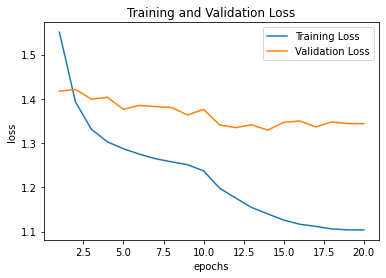

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
y.pop()

tensor([0, 5, 5, 5, 5, 2, 0, 4, 1, 5, 0, 5, 5], device='cuda:0')

In [ ]:
prediction.pop()

tensor([0, 5, 5, 5, 5, 4, 1, 2, 1, 5, 0, 5, 2], device='cuda:0')

In [ ]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [ ]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [ ]:
true_y.shape

(41, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.78      0.68      0.72       240
Comparison or Contrast       0.80      0.73      0.76       187
               Extends       0.29      0.44      0.35        32
                Future       0.82      0.82      0.82        17
            Motivation       0.41      0.70      0.52        56
                  Uses       0.76      0.73      0.74       124

              accuracy                           0.69       656
             macro avg       0.64      0.68      0.65       656
          weighted avg       0.73      0.69      0.71       656



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[162,  18,  13,   0,  35,  12],
       [ 20, 136,   7,   3,  16,   5],
       [  2,   7,  14,   0,   2,   7],
       [  2,   0,   0,  14,   0,   1],
       [  8,   6,   0,   0,  39,   3],
       [ 13,   3,  15,   0,   3,  90]])

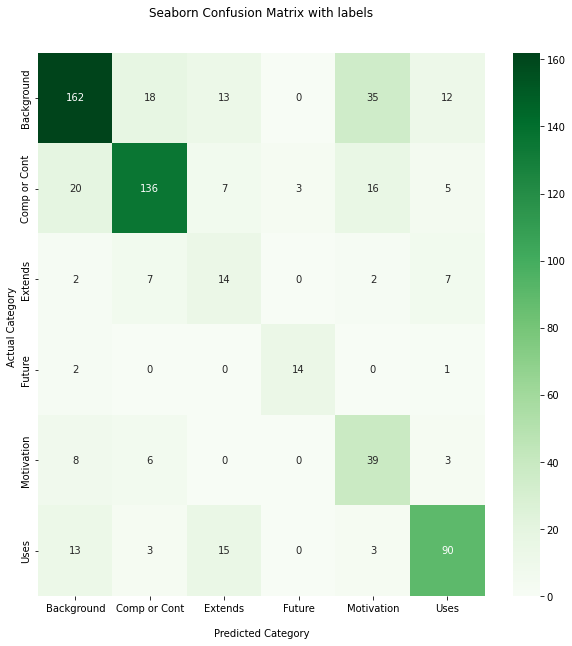

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()


**Testing**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [ ]:
tot_labels.pop()

tensor([1, 1, 0, 1, 0, 0, 5, 1, 4, 0, 5, 5], device='cuda:0')

In [ ]:
tot_pred.pop()

tensor([1, 5, 1, 1, 0, 2, 5, 1, 4, 2, 5, 0], device='cuda:0')

In [ ]:
input_ids.pop()

tensor([[ 102,  547, 1139,  ...,    0,    0,    0],
        [ 102,  111,  705,  ...,    0,    0,    0],
        [ 102,  906,  111,  ...,    0,    0,    0],
        ...,
        [ 102,  256, 3017,  ...,    0,    0,    0],
        [ 102,  168,  535,  ...,    0,    0,    0],
        [ 102,  705,  422,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [ ]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [ ]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.75      0.73      0.74       117
Comparison or Contrast       0.70      0.69      0.69        90
               Extends       0.48      0.62      0.54        16
                Future       0.70      0.88      0.78         8
            Motivation       0.46      0.63      0.53        27
                  Uses       0.86      0.69      0.77        62

              accuracy                           0.70       320
             macro avg       0.66      0.71      0.67       320
          weighted avg       0.72      0.70      0.71       320



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[85, 18,  3,  0, 10,  1],
       [13, 62,  3,  2,  7,  3],
       [ 2,  1, 10,  0,  0,  3],
       [ 1,  0,  0,  7,  0,  0],
       [ 6,  3,  1,  0, 17,  0],
       [ 6,  5,  4,  1,  3, 43]])

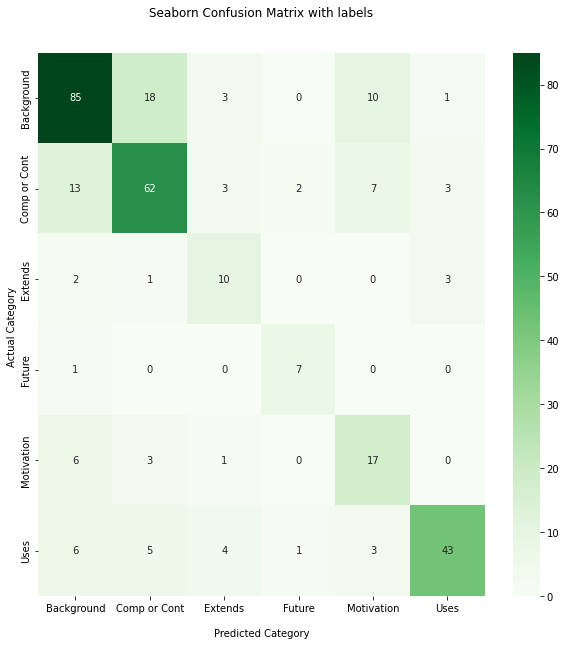

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()
plt.savefig("cf_testing1.png")

In [ ]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [ ]:
df['predictions']=df['predictions'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})
df['Actual Label']= df['Actual Label'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})

In [ ]:
df

,Actual Label,Tokenised Text,predictions
0,Comp or Cont,"[[CLS], the, left, ##most, reduction, from, an, almost, linear, λ, -, term, to, its, normal, form, must, be, non, -, deleting, and, almost, non, -, dup, ##lica, ##ting, in, the, sense, that, when, a, β, -, red, ##ex, (, λ, ##x, ., p, ), q, is, contracted, ,, q, is, not, deleted, ,, and, moreover, it, is, not, duplicated, unless, the, type, of, x, is, atomic, ., we, can, show, that, the, subjec...",Extends
1,Comp or Cont,"[[CLS], in, addition, ,, huge, word, -, trig, ##ram, tables, need, to, be, available, at, run, time, ., moreover, ,, word, trig, ##ram, ##s, are, ineffective, at, capturing, long, ##distance, properties, such, as, discourse, topic, and, tens, ##e, ., feature, -, based, approaches, ,, such, as, bayesian, classi, ##fte, ##rs, (, CITSEG, ), ,, decision, lists, (, CITSEG, ), ,, and, bayesian, hybr...",Comp or Cont
2,Uses,"[[CLS], that, ,, at, least, for, the, bu, -, lc, parser, ,, parse, time, is, related, roughly, quadratic, ##ally, to, input, length, ., in, previous, work, with, the, an, ##lt, ,, throughput, with, raw, corpus, data, was, worse, than, that, observed, in, these, experiments, ,, though, probably, only, by, a, constant, factor, ., this, could, be, due, to, the, fact, that, the, vocabulary, of, th...",Background
3,Motivation,"[[CLS], several, efficient, ,, accurate, and, robust, approaches, to, data, -, driven, dependency, parsing, have, been, proposed, recently, (, CITSEG, ), for, syntactic, analysis, of, natural, language, using, bile, ##xi, ##cal, dependency, relations, (, CITSEG, ), ., much, of, the, appeal, of, these, approaches, is, tied, to, the, use, of, a, simple, formalism, ,, which, allows, for, the, use...",Background
4,Comp or Cont,"[[CLS], this, allows, us, to, give, guarantees, of, convergence, ., furthermore, ,, we, also, evaluate, the, method, on, alternate, extrinsic, loss, functions, ., CITSEG, presented, a, percept, ##ron, -, based, algorithm, for, learning, the, phrase, -, translation, parameters, in, a, statistical, machine, translation, system, ., similar, to, the, in, ##line, -, rank, ##er, loss, function, pres...",Comp or Cont
5,Motivation,"[[CLS], is, ##word, ., *, left, ##to, ##ken, ., is, ##word, ., ist, ##it, ##le, ., *, left, ##to, ##ken, ., is, ##word, ., ist, ##it, ##le, ., equals, ., *, left, ##to, ##ken, ., is, ##word, ., ist, ##it, ##le, ., equals, ., mr, table, 1, :, a, few, examples, of, the, feature, hierarchy, to, the, named, entity, status, of, the, current, word, ., this, is, easily, accomplished, by, back, ##ing,...",Motivation
6,Uses,"[[CLS], the, first, task, is, pos, tagging, ,, for, which, we, used, 61, ##66, ws, ##j, sentences, from, sections, 00, and, 01, of, penn, tree, ##bank, as, the, source, domain, data, ,, and, 273, ##0, pubmed, sentences, from, the, oncology, section, of, the, penn, ##bio, ##ie, corpus, as, the, target, domain, data, ., the, second, task, is, entity, type, classification, ., the, setup, is, very...",Comp or Cont
7,Comp or Cont,"[[CLS], the, model, instead, of, employing, the, source, -, channel, paradigm, for, tagging, (, more, or, less, explicitly, present, e, ., g, ., in, (, CITSEG, ), ,, (, CITSEG, ), ,, (, ha, ##ji, ##s, ,, hla, ##dk, ##a, ,, 1997, ), ), used, in, the, past, (, notwithstanding, some, exceptions, ,, such, as, maximum, entropy, and, rule, -, based, tag, ##gers, ), ,, we, are, using, here, a, "", dir...",Comp or Cont
8,Comp or Cont,"[[CLS], the, algorithm, employs, a, compact, representation, of, the, correspondences, for, efficient, operation, ., an, arbitrarily, large, corpus, can, be, accommodate, ##d, by, segment, ##ing, it, appropriately, ., the, algorithm, described, here, is, an, instance, of, a, general, approach, to, statistical, estimation, ,, represented, by, the, em, algorithm, [, CITSEG, ], ., in, contrast, t...",Comp or Cont
9,Background,"[[CLS], this, study, differs, from, their, work, because, we, concentrate, on, constructing, tree, struct